In [ ]:
import numpy as np
import pandas as pd
import torch
import math as m
import os
import matplotlib.pyplot as plt
from google.colab import drive
from torch.utils.data import DataLoader
!pip install colour
from colour import Color
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class AutoEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = torch.nn.Sequential(
      torch.nn.Linear(100, 70),
      torch.nn.ReLU(),
      torch.nn.Linear(70, 40),
      torch.nn.ReLU(),
      torch.nn.Linear(40, 20),
      torch.nn.ReLU(),
      torch.nn.Linear(20, 10),
      torch.nn.ReLU(),
      torch.nn.Linear(10, 2)
    )
    self.decoder = torch.nn.Sequential( 
      torch.nn.ReLU(),
      torch.nn.Linear(2, 10),
      torch.nn.ReLU(),
      torch.nn.Linear(10, 20),
      torch.nn.ReLU(),
      torch.nn.Linear(20, 40),
      torch.nn.ReLU(),
      torch.nn.Linear(40, 70),
      torch.nn.ReLU(),
      torch.nn.Linear(70, 100),
      torch.nn.Sigmoid()
    )

  def forward(self, x):
    latent_space = self.encoder(x)
    return self.decoder(latent_space)

In [ ]:
class Penguin:
  def __init__(self, epochs, num_batches, learning_rate=0.001):
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.loss_func = torch.nn.MSELoss()
    self.model = AutoEncoder()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    self.losses = []
    self.predictions = []
    self.num_batches = num_batches
  
  def train(self, x):
    dataloader = DataLoader(x, batch_size=(m.ceil(x.shape[0]/self.num_batches)))
    for epoch in range(self.epochs):
      for batch in dataloader:
        pred = self.model(batch)
        self.predictions.append(pred)
        loss = self.loss_func(pred, batch)
        self.losses.append(loss.detach().numpy())
        self.model.zero_grad()
        loss.backward(retain_graph=True)
        with torch.no_grad():
            for param in self.model.parameters():
              param -= self.learning_rate * param.grad
        self.optimizer.step()
    return self.predictions

  def save(self):
    torch.save(self.model.state_dict(), '/content/model.zip') 
    
  def graph_loss(self):
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    x = np.arange(1/self.num_batches, self.epochs+1/self.num_batches, 1/self.num_batches)
    y = self.losses
    plt.plot(x, y)
    plt.xlim(0)
    plt.ylim(0)

  def test(self, x_test):
    weights = torch.load('/content/model.zip')
    self.model.load_state_dict(weights)
    self.model.eval()
    pred = self.model(x_test)
    loss = self.loss_func(pred, x_test).detach().numpy()
    return loss, pred.detach().numpy()

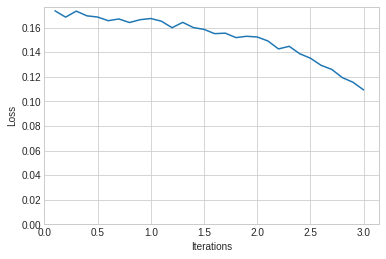

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Project_MTL/data/SyntheticData/test.csv').drop(columns='Unnamed: 0')
train = pd.read_csv('/content/drive/MyDrive/Project_MTL/data/SyntheticData/train.csv').drop(columns='Unnamed: 0')

X = torch.tensor(train.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32).to(torch.float32)
X_test = torch.tensor(test.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32).to(torch.float32)

handler = Penguin(3, 10)
handler.train(X)
handler.graph_loss()
handler.save()